In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import anndata as ad
import scanpy as sc
import seaborn as sns
import yaml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lab_scripts.utils import utils
utils.change_directory_to_repo()

from lab_scripts.data import dataloader
from lab_scripts.data.integration import processor
from lab_scripts.mains.mp import preprocessing, common
from lab_scripts.models.mp import model

In [2]:
with open('configs/mp/mp/gex_to_adt.yaml', 'r') as f:
    config = yaml.safe_load(f)
data_config = config['data']
dataset = dataloader.load_data(
    data_config["dataset_name"],
    val_size=data_config["val_size"],
    filter_genes=(data_config["gene_fraction"], "data/genes.csv"),
)

-1.3947728872299194


In [34]:
dataset['train_mod1'].obs['batch']

ATGGAGGAGAGTGGCT-1-s1d1    s1d1
GGAGGATAGGTCCTGC-1-s3d6    s3d6
TCATGGATCGGATTAC-1-s2d1    s2d1
CGGCAGTTCCCTCATG-1-s1d1    s1d1
CTCAATTTCTCTCCGA-1-s3d6    s3d6
                           ... 
TGCTTGCCAGCATACT-1-s2d1    s2d1
GTAAGTCTCCTCAGAA-1-s3d6    s3d6
CCGGTAGTCGCTGACG-1-s3d6    s3d6
AGCCAGCGTACACGCC-1-s2d1    s2d1
TGTTGAGCATCATCCC-1-s2d4    s2d4
Name: batch, Length: 28565, dtype: category
Categories (4, object): ['s1d1', 's2d1', 's2d4', 's3d6']

In [8]:
all_gex = ad.concat([dataset['train_mod1'], dataset['test_mod1']])

In [9]:
X = all_gex.X.toarray()

In [11]:
pca = PCA(n_components=75)
X = pca.fit_transform(X)

In [12]:
tsne = TSNE(n_jobs=-1)
X = tsne.fit_transform(X)

/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
fac = pd.factorize( all_gex.obs['batch'])

In [33]:
np.unique(fac[0])

array([0, 1, 2, 3, 4])

In [23]:
fac[0].max()

4

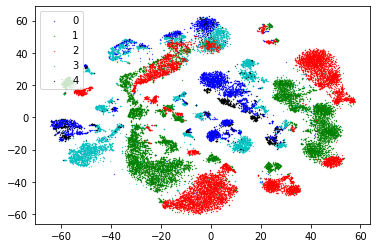

In [32]:
colors = ['b', 'g', 'r', 'c', 'k']
plots = []
names = []
for i in range(5):
    idx = fac[0] == i
    plots.append(plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], s=0.1))
    names.append(str(i))
plt.legend( plots, names)

In [15]:
sc.tl.tsne(all_gex)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


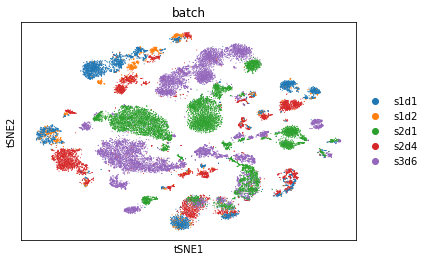

In [19]:
sc.pl.tsne(all_gex, color='batch')

In [4]:
model_config = config['model']
first_train, first_val, first_test, first_input_features = preprocessing.preprocess_one_dataset(
    data_config["mod1"],
    dataset["train_mod1"],
    dataset['val_mod1'],
    dataset["test_mod1"],
    data_config["task_type"],
    True,
)

In [33]:
first_train

{'X': tensor([[-0.4694, -0.1318, -0.1435,  ..., -0.5919, -0.6935, -0.4301],
         [-0.4694, -0.1318, -0.1435,  ...,  2.0492, -0.6935,  0.7742],
         [-0.4694, -0.1318, -0.1435,  ...,  0.3973,  1.3432,  1.2387],
         ...,
         [-0.4694, -0.1318, -0.1435,  ...,  0.6946, -0.6935, -0.3297],
         [ 2.6228, -0.1318, -0.1435,  ..., -0.8826, -0.6935, -0.1993],
         [-0.4694, -0.1318, -0.1435,  ...,  2.0297, -0.6935,  0.6623]]),
 'inverse': <function lab_scripts.data.integration.processor.Processor._get_inverse_transform.<locals>.f(matrix: torch.Tensor, small_idx: numpy.ndarray = None)>,
 'batch_idx': tensor([0, 1, 2,  ..., 1, 3, 2])}

In [43]:
first_train['inverse'](first_train['X']).std()

0.7286711

In [55]:
first_test['inverse'](first_test['X']).max()

12.820647

In [56]:
dataset['test_mod1'].X.toarray().max()

12.820647

In [47]:
second_train, second_val, second_test, second_input_features = preprocessing.preprocess_one_dataset(
    data_config["mod2"],
    dataset["train_mod2"],
    dataset['val_mod2'],
    dataset["test_mod2"],
    data_config["task_type"],
    True,
)

In [64]:
second_train['inverse'](second_train['X']).max()

7.514117

In [65]:
dataset['train_mod2'].X.toarray().max()

7.514117

In [5]:
preprocessed_data = preprocessing.preprocess_data(data_config, dataset, model_config['batch_size'], is_train=True)

In [6]:
preprocessed_data

{'train_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7ff16055d4c0>,
 'test_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7ff120fda340>,
 'test_shuffled_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7ff120fda430>,
 'val_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7ff120fda0a0>,
 'small_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7ff120fda1c0>,
 'small_idx': array([ 4032,  4929, 22755,  5787,  6827,   714, 22791,  9488,  7064,
        26289,  8962,  5358, 18582,  6072,  3265, 14526,  7998, 16957,
         4952, 14134, 24671, 14288,  6014, 23384, 13534,  6187, 16228,
        27322, 26633, 23382, 24667,  1720,  6252,  7740, 25258, 21720,
        20484, 23436, 27095, 25821, 21456,  2761, 11202, 28295, 18613,
        24093,  2560, 21533,  1286, 24915,  5542, 12206,  2856,  5071,
        19215, 26185, 14187, 23299,  7757, 20957,  7443,  8207, 19601,
        20068, 14482,   638, 23237,  4194,  3720,  7072, 25369, 20639,
        1

In [69]:
dataset['train_mod1'].obs['batch'].value_counts()

s3d6    9804
s2d1    9199
s2d4    4921
s1d1    4641
Name: batch, dtype: int64

In [72]:
torch.unique(preprocessed_data['train_batch_idx'], return_counts=True)

(tensor([0, 1, 2, 3]), tensor([4921, 9804, 4641, 9199]))

In [7]:
train_dataloader = preprocessed_data["train_dataloader"]
test_shuffled_dataloader = preprocessed_data['test_shuffled_dataloader']
model_config = common.update_model_config(model_config, preprocessed_data)

[1.54238661 0.72892212 0.77706746 1.4432599 ]


{'feature_extractor_dims': [1394, 2000, 700, 500, 300],
 'fe_dropout': [2],
 'regression_dims': [300, 100, 100, 134],
 'regression_dropout': [],
 'activation': 'selu',
 'lr': 0.001,
 'balance_classes': True,
 'attack': 10,
 'sustain': 1500,
 'release': 500,
 'batch_size': 128,
 'gradient_clip': 1.0,
 'inject_test': True,
 'black_and_white': False,
 'l2_lambda': 0.0,
 'dropout': 0.5,
 'use_mmd_loss': False,
 'mmd_lambda': 0.1,
 'use_l2_loss': False,
 'l2_loss_lambda': 0.01,
 'use_coral_loss': False,
 'coral_lambda': 10.0,
 'use_critic': True,
 'critic_type': 'ganin',
 'critic_lambda': 0.01,
 'critic_gamma': 1.0,
 'critic_dims': [300, 300, 100],
 'normal_iterations': 1,
 'critic_iterations': 1,
 'critic_lr': 0.001,
 'use_vi_dropout': False,
 'vi_lambda': 0.5,
 'vi_attack': 30,
 'total_batches': 4,
 'batch_weights': array([1.45117862, 0.72840167, 1.53873088, 0.77630721])}